# Performance of LSH for coreferences

In [1]:
from load_coreferences import load_coreferences, load_pairs
# import lsh 
from REL import lsh 
import copy
import numpy as np
import time 
import matplotlib.pyplot as plt

import cProfile

scaling_factor = 5 # multiply size the original data set by this factor

In [2]:
all_pairs = load_pairs()
raw_mentions = load_coreferences()
mentions = {i: m for i, m in enumerate(raw_mentions)}


#### Effectiveness

In [3]:
def evaluate_coref_predictions(pairs_gold, candidates, _return = False):
    "Precision and recall for LSH coref pair search"
    missed = 0 
    correct = 0 
    wrong = 0

    for mention, true_reference in pairs_gold.items():
        current_candidates = candidates[mention]

        if true_reference not in current_candidates:
            missed += 1
        for candidate in current_candidates:
            if candidate == true_reference:
                correct += 1
            elif candidate != true_reference:
                wrong += 1


    precision = correct / (correct + wrong)
    recall = correct / (correct + missed)

    ndig = 3
    if not _return:
        print(f"Precision: {round(precision, ndig)}") # note: lower precision means larger comparison set for coref classification.
        print(f"Recall: {round(recall, ndig)}") 
    else:
        return (precision, recall)

In [4]:
pairs_gold = {}
for pair_doc in all_pairs.values():
    for p in pair_doc:
        pairs_gold[p[1]] = p[0] # key = mention, value = true coreference



Make signature with a while loop 

In [6]:
mylsh = lsh.LSHMinHash(mentions=mentions, shingle_size=3, signature_size=800, band_length=10)

mylsh.cluster(candidates="new")
mylsh.summarise()
candidates = {mention: [mentions[i] for i in mylsh.candidates[idx]] for idx, mention in mentions.items()}

evaluate_coref_predictions(pairs_gold, candidates)


took 0.04050111770629883 seconds for 174 mentions
average, min, max cluster size: 18.55, 8, 39
Precision: 0.047
Recall: 0.931


Properties    
- longer signature $\rightarrow$ higher recall, lower precision
- larger shingle $\rightarrow$ lower recall, higher precision
- longer band $\rightarrow$ lower recall, higher precision


In [7]:

max_signature_size = 1500
min_signature_size = 100
# band_lengths = [2, 3, 4] # varying band lengths gives not strictly increasing ROC curve
band_lengths = [15]
shingle_sizes = [2,3,4]

measure_dict = {}

for shingle_size in shingle_sizes:
    l = band_lengths[0]
    measurements = []
    start_size = min_signature_size - (min_signature_size % l) + l # start at next multiple of l
    for s in range(start_size, max_signature_size, l):
        mylsh = lsh.LSHMinHash(mentions=mentions, shingle_size=shingle_size, signature_size=s, band_length=l)

        mylsh.cluster()
        candidates = {mention: [mentions[i] for i in mylsh.candidates[idx]]  for idx, mention in mentions.items()}

        m = evaluate_coref_predictions(pairs_gold, candidates, _return=True)
        out = m + (s,)
        measurements.append(out)
    measure_dict[shingle_size] = measurements


In [8]:
md = {k: [
    [1 - i[0] for i in measures], # fpr
    [i[1] for i in measures], # recall,
    [i[2] for i in measures] # signature size
] for k, measures in measure_dict.items()}


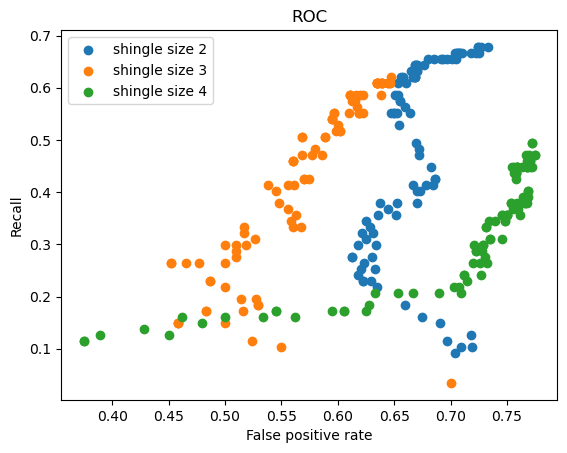

In [9]:
fig, ax = plt.subplots()
for k, v in md.items():
    lbl = f"shingle size {k}"
    ax.scatter(x=v[0], y=v[1], label=lbl)

ax.set_xlabel("False positive rate")
ax.set_ylabel("Recall")
ax.set_title("ROC")
ax.legend()

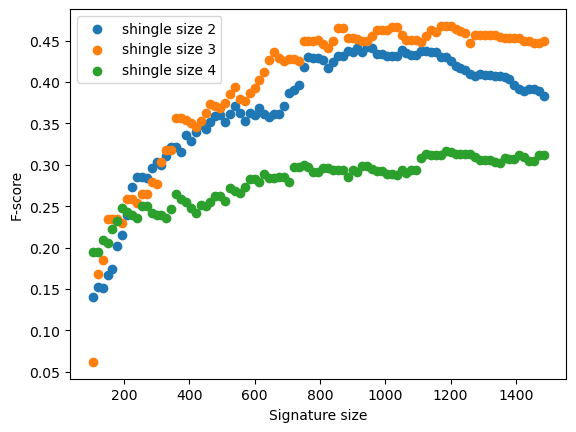

In [10]:
fig, ax = plt.subplots()
for k, v in md.items():
    precision = np.array([1-i for i in v[0]])
    recall = np.array([i for i in v[1]])
    fscore = 2 * precision * recall / (precision + recall)
    lbl = f"shingle size {k}"
    ax.scatter(y=fscore, x=v[2], label=lbl)

ax.set_ylabel("F-score")
ax.set_xlabel("Signature size")
ax.legend()

Notes 
- trade off: get the same recall for smaller false positive rate with larger shingle size, but need a larger signature and thus more time 
    - improve the calculation of the signature?
    - another benefit however is that with a smaller false positive rate, the `with_coref` call in REL will be faster (smaller comparison sets)
    - also important: higher false positive rate means more comparisons also for those mentions that are *not* coreferences (and are not in the present dataset).
    - check again the time complexity of this -- signature length of 300 may not be feasible/lead to long computing time when data set is a few thousands of mentions
- add color shading for shingle size? --
- the can look like they have a negative slope (particularly for shingle size 4). Not sure why. Also happened when I varied the band lengths. does it have to do with the ordering of the input to the plot? 

#### Profiling

In [13]:
mylsh = lsh.LSHMinHash(mentions=mentions, shingle_size=2, signature_size=800, band_length=10)



# %timeit mylsh.make_signature
# %timeit mylsh.make_signature_np

%timeit mylsh.cluster(candidates="old")
%timeit mylsh.cluster(candidates="new")

30 ms ± 1.56 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
37.1 ms ± 1.12 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [5]:

cProfile.run("mylsh.cluster(candidates='old')")
# cProfile.run("mylsh.make_signature()")


         188421 function calls (176179 primitive calls) in 0.096 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        2    0.000    0.000    0.000    0.000 <__array_function__ internals>:177(append)
       80    0.000    0.000    0.001    0.000 <__array_function__ internals>:177(argsort)
       81    0.000    0.000    0.023    0.000 <__array_function__ internals>:177(array_split)
      348    0.000    0.000    0.001    0.000 <__array_function__ internals>:177(atleast_1d)
      523    0.000    0.000    0.001    0.000 <__array_function__ internals>:177(atleast_2d)
      174    0.000    0.000    0.003    0.000 <__array_function__ internals>:177(broadcast_arrays)
      174    0.000    0.000    0.001    0.000 <__array_function__ internals>:177(broadcast_to)
      736    0.000    0.000    0.001    0.000 <__array_function__ internals>:177(can_cast)
       84    0.000    0.000    0.000    0.000 <__array_function__ internals>:177

In [14]:

# stack mentions on top of each other 
mentions_scaled = copy.copy(mentions)

idx = len(mentions_scaled)
for i in range(1, scaling_factor):
    for idx_old in mentions.keys():
        m = mentions[idx_old]
        mentions_scaled[idx] = m 
        idx += 1

In [15]:
print(f"scaling factor is {scaling_factor}")
mylsh = lsh.LSHMinHash(mentions=mentions_scaled, shingle_size=2, signature_size=800, band_length=10)

cProfile.run("mylsh.cluster(candidates='new')") # scaling factor 10: 0.233 for new, 0.494 for old 

scaling factor is 5
         270656 function calls (258889 primitive calls) in 0.120 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    0.002    0.002 <__array_function__ internals>:177(argsort)
       80    0.000    0.000    0.019    0.000 <__array_function__ internals>:177(array_split)
        1    0.000    0.000    0.000    0.000 <__array_function__ internals>:177(atleast_2d)
       38    0.000    0.000    0.000    0.000 <__array_function__ internals>:177(can_cast)
        3    0.000    0.000    0.000    0.000 <__array_function__ internals>:177(concatenate)
        2    0.000    0.000    0.000    0.000 <__array_function__ internals>:177(copyto)
       82    0.000    0.000    0.002    0.000 <__array_function__ internals>:177(cumsum)
       80    0.000    0.000    0.000    0.000 <__array_function__ internals>:177(diff)
        2    0.000    0.000    0.000    0.000 <__array_function__ internals>:

In [16]:
mylsh = lsh.LSHMinHash(mentions=mentions_scaled, shingle_size=2, signature_size=800, band_length=10)
mylsh._build_vocab()
mylsh.encode_binary()
mylsh.make_signature()


cProfile.run("mylsh.get_candidates_new()")


         258602 function calls (246839 primitive calls) in 0.097 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    0.002    0.002 <__array_function__ internals>:177(argsort)
       80    0.000    0.000    0.020    0.000 <__array_function__ internals>:177(array_split)
        1    0.000    0.000    0.000    0.000 <__array_function__ internals>:177(concatenate)
        1    0.000    0.000    0.000    0.000 <__array_function__ internals>:177(copyto)
       81    0.000    0.000    0.002    0.000 <__array_function__ internals>:177(cumsum)
       80    0.000    0.000    0.000    0.000 <__array_function__ internals>:177(diff)
        2    0.000    0.000    0.000    0.000 <__array_function__ internals>:177(fliplr)
       80    0.000    0.000    0.000    0.000 <__array_function__ internals>:177(nonzero)
        1    0.000    0.000    0.002    0.002 <__array_function__ internals>:177(sort)
       80    0.

Performance of get_candidates

In [18]:
mylsh = lsh.LSHMinHash(mentions=mentions_scaled, shingle_size=2, signature_size=800, band_length=10)
mylsh._build_vocab()
mylsh.encode_binary()
mylsh.make_signature()


%timeit mylsh.get_candidates()
%timeit mylsh.get_candidates_new() # does not make it faster!

86.2 ms ± 348 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
70.4 ms ± 1.79 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


Summary: how to improve the nested for loop for get_candidates.


All these things did not work:
```python
groups = [[3,4], [1,2], [1,4], [0, 3]]
cands = [set() for _ in range(5)]

def add_candidates(cands, g):
    for i in list(g):
        # print(i)
        cands[i].update(g)

cands = itertools.starmap(add_candidates, itertools.zip_longest([], groups, fillvalue=cands))

out = map(add_candidates, groups, itertools.repeat(cands, len(groups)))
list(out)

myiter = itertools.chain(groups)
for i in myiter:
    print(i)   
```

I also tried `defaultdict(set)` but that also did not speed up. Perhaps because it required some unpacking after collecting the buckets.

Performance of one-hot encoding

- using sklearn binarizer instead of the ad-hoc approach speeds up by a factor of about 100
- the ad-hoc approach first created a sparse matrix of 0s, and then replaced the respective positions with a 1. This required shuffling between `csr_matrix` and `lil_matrix` which is not efficient.

In [10]:
mylsh = lsh.LSHMinHash(mentions=mentions_scaled, shingle_size=2, signature_size=800, band_length=10)
mylsh._build_vocab()


%timeit mylsh.encode_binary()

1.15 ms ± 5.68 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


#### Time analysis for sorting multidimensional array along one axis

In [ ]:
# keep this for some time analysis
    # mult before sort -- adapt from the now helper function cols_to_int
x = np.array([[0, 3], [2, 2], [2, 2], [0, 3]]) 
x = np.array([[1, 3], [2, 2], [2, 2], [1, 3], [1, 5], [1, 1]]) # this is one test case
A = np.array([[3,4], [3,5], [5,6], [3,4], [6,7]]) # this is another test case

display(A)
display(np.argsort(A, axis=0))
display(A.view('i8,i8').argsort(order=['f1'], axis=0))

display(x)
display(np.argsort(x, axis=0))
display(x.view('i8,i8').argsort(order=['f1'], axis=0))


n = 100_000
A = np.random.choice(np.arange(int(n/100)), size=(n,2))
%timeit np.argsort(A, axis=0)
%timeit A.view('i8,i8').argsort(order=['f1'], axis=0)
%timeit mult_before_sort(A)

Alternatives to take along axis? -- for reshape

In [21]:
a = np.arange(4000).reshape(200,4,5)
n_reps, n_rows, n_cols = a.shape

a = a.reshape(n_reps*n_rows, n_cols)
idx = np.arange(n_reps*n_rows).reshape(n_reps, n_rows).T.reshape(-1,1)

def new_approach(a):
    a = a[idx,:].squeeze().reshape(n_rows, n_reps, n_cols)
    return a

def old_approach(a):
    a = np.take_along_axis(a, idx, axis=0).reshape(n_rows, n_reps, n_cols)
    return a 

In [22]:
assert np.all(new_approach(a) == old_approach(a))

In [23]:
%timeit old_approach(a)
%timeit new_approach(a)

14.7 µs ± 40.6 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)
7.18 µs ± 37.6 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [25]:
cProfile.run("new_approach(a)")

         6 function calls in 0.000 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    0.000    0.000 1295725854.py:7(new_approach)
        1    0.000    0.000    0.000    0.000 <string>:1(<module>)
        1    0.000    0.000    0.000    0.000 {built-in method builtins.exec}
        1    0.000    0.000    0.000    0.000 {method 'disable' of '_lsprof.Profiler' objects}
        1    0.000    0.000    0.000    0.000 {method 'reshape' of 'numpy.ndarray' objects}
        1    0.000    0.000    0.000    0.000 {method 'squeeze' of 'numpy.ndarray' objects}




for minhash function

In [120]:
rng = np.random.default_rng(1)
x = rng.normal(0,1,100_000).reshape(100,1000)


In [121]:
n_reps = 200
indices = np.arange(x.shape[1])
rng = np.random.default_rng(3)

# expand by n_reps 
indices_mult = np.tile(indices, (n_reps, 1)) # reorder the columns n_reps times 
x_mult = np.tile(x, (n_reps, 1)).reshape((n_reps,) + x.shape) # new shape: (n_resp, x.shape[0], x.shape[1
permuted_indices = rng.permuted(indices_mult, axis=1)


In [122]:

def old_approach(a, permuted_indices):
    out = np.take_along_axis(a, permuted_indices[:, np.newaxis, :], 2)
    return out 

def new_approach(a, permuted_indices):
    I = np.arange(a.shape[0])[:, np.newaxis]
    out = a[I, :, permuted_indices].swapaxes(1,2)
    return out 

assert np.all(new_approach(x_mult, permuted_indices) == old_approach(x_mult, permuted_indices))


In [123]:
%timeit -n 100 old_approach(x_mult, permuted_indices)
%timeit -n 100 new_approach(x_mult, permuted_indices)

99.1 ms ± 4.48 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
47.5 ms ± 2.07 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [42]:


band_length = 10
n_items = 5
n_bands = 2
signature_length = n_bands * band_length

M = np.ones((n_items, signature_length))

M = M.reshape(n_bands, n_items, -1)
assert M.shape[2] == band_length

M.shape



(2, 5, 10)

In [307]:
def vectorize_signature_bands(a, n_bands, band_length):
    """ 
    Convert a signature array of dimension (n_items, signature_length) into an array of (n_bands, n_items, band_length).
    
    This is a vectorized version for np.vstack(np.split(a, indices_or_sections=n_bands, axis=1)). 
    The idea is to then use a vectorized function to extract the indices, instead of looping over each element in the output of np.split().
    """
    n_items, signature_length = a.shape
    
    # stacked bands of each item, stacked together
    stacked_bands = a.reshape(n_items*n_bands, band_length) 
    # reorder so that the first band of all items comes first, then the second band of all items
    reordering_vector = np.arange(n_items*n_bands).reshape(n_items, n_bands).T.reshape(1, -1)

    result = stacked_bands[reordering_vector, :].reshape(n_bands, n_items, band_length)
    
    return result 


def group_unique_indices(a):
    """
    calculate groups of indices of unique rows in a multidimensional array with the same signature
    the groups are returned by band.

    Returns a list of lists. One list corresponds to each band, and it indicates the rows
    of a that have the same band.
    """
    n_bands, n_items, length_band = a.shape
    a = cols_to_int(a).squeeze()
    
    sort_idx = np.argsort(a, axis=1) # necessary for later, need to calc anyway
    a_sorted = np.sort(a, axis=1) # faster alternative to np.take_along_axis(b, sort_idx, axis=1)

    # indicators for where a sequence of different unique elements starts 
    indicators =  a_sorted[:, 1:] != a_sorted[:, :-1]
    first_element = np.tile([[True]], n_bands).T 
    unq_first = np.concatenate((first_element, indicators), axis=1)

    # calculate number of unique items 
    unq_count = [np.diff(np.nonzero(row)[0]) for row in unq_first] # iterate through rows. 
    unq_idx = [np.split(sort_idx[i], np.cumsum(count)) for i, count in enumerate(unq_count)]

    return unq_idx




In [312]:
## test 
a = np.array([[1, 4, 7, 8, 10, 8], [5, 3, 2, 6, 11, 0], [1, 4, 2, 6, 13, 15]])

n_bands = 2
n_items = a.shape[0]
band_length = int(a.shape[1]/n_bands)
result = vectorize_signature_bands(a, n_bands=n_bands, band_length=band_length)

expected = np.vstack(np.split(a, n_bands, axis=1)).reshape(n_bands, n_items, -1)

assert np.all(result == expected), "signature bands not vectorized correctly"



In [490]:
def cols_to_int_multidim(a):
    "combine columns in all rows to an integer: [[1,20,3], [1,4,10]] becomes [1203,1410]"
    existing_powers = np.floor(np.log10(a))
    n_bands, nrows, ncols = a.shape 

    cumsum_powers = np.fliplr(np.cumsum(np.fliplr(existing_powers), axis=1))

    add_powers = [x for x in reversed(range(ncols))]
    add_powers = np.tile(add_powers, (nrows, 1))

    mult_factor = cumsum_powers - existing_powers + add_powers  
    summationvector = np.ones((ncols, 1)) 
    out = np.matmul(a * 10**mult_factor, summationvector)
    return out 


In [499]:
def group_unique_indices(a):
    """
    calculate groups of indices of unique rows in a multidimensional array with the same signature
    the groups are returned by band.

    Returns a list of lists. One list corresponds to each band, and it indicates the rows
    of a that have the same band.
    """
    n_bands, n_items, length_band = a.shape
    a = cols_to_int_multidim(a).squeeze()
    
    sort_idx = np.argsort(a, axis=1) # necessary for later, need to calc anyway
    a_sorted = np.sort(a, axis=1) # faster alternative to np.take_along_axis(b, sort_idx, axis=1)

    # indicators for where a sequence of different unique elements starts 
    indicators =  a_sorted[:, 1:] != a_sorted[:, :-1]
    first_element = np.tile([[True]], n_bands).T 
    unq_first = np.concatenate((first_element, indicators), axis=1)

    # calculate number of unique items 
    unq_count = [np.diff(np.nonzero(row)[0]) for row in unq_first] # iterate through rows. 
    unq_idx = [np.split(sort_idx[i], np.cumsum(count)) for i, count in enumerate(unq_count)]

    return unq_idx

In [504]:
a = np.array([[1, 4, 7, 8], [1, 4, 2, 7], [5, 3, 2, 6]])
n_bands = 2
n_items = a.shape[0]
band_length = int(a.shape[1]/n_bands)
a = vectorize_signature_bands(a, n_bands=n_bands, band_length=band_length)

# print("a before cols_to_int:")
display(a)
# print("after:")
# a = cols_to_int_multidim(a)
display(a)
a = group_unique_indices(a)
a

array([[[1, 4],
        [1, 4],
        [5, 3]],

       [[7, 8],
        [2, 7],
        [2, 6]]])

array([[[1, 4],
        [1, 4],
        [5, 3]],

       [[7, 8],
        [2, 7],
        [2, 6]]])

[[array([0, 1]), array([2])], [array([2]), array([1]), array([0])]]

In [509]:
k = [list(i) for i in a[0]]
len(k[1])

1

[[array([2]), array([1]), array([0])], [array([2]), array([1]), array([0])]]